# 深層学習で数字認識 AI

## １ 目的

人工知能ライブラリ Keras で MNIST データを学習させ、手書き数字を認識できる人工知能（モデル）を作る。

## ２ 準備

### プログラム・セットアップ

このプログラムは主に Keras.io の [MNIST 手書き数字データベースを利用する数字認識モデルを学習する例](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py) に基づいたものである。

* [Keras](https://keras.io/) Python の深層学習ライブラリ
   * [日本語版のドキュメンテーショんはこちら](https://keras.io/ja/)
* Keras の利用するテンソル計算ライブラリ [TensorFlow](https://www.tensorflow.org/) (ニューラルネットワーク)
* [Python](https://www.python.jp/pages/about.html) プログラミング言語
* [Jupyter](https://jupyter.org/) ブラウザーでのプログラム実行環境
* [NumPy](https://ja.wikipedia.org/wiki/NumPy) プログラミング言語 Python における数値計算ライブラリ
* [Matplotlib](https://ja.wikipedia.org/wiki/Matplotlib) プログラミング言語 Python およびその科学計算用ライブラリ NumPy のためのグラフ描画ライブラリ

In [1]:
%matplotlib notebook

import keras
import numpy as np
import os
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 
                               'Yu Gothic', 
                               'Meirio', 
                               'Takao', 
                               'IPAexGothic', 
                               'IPAPGothic', 
                               'VL PGothic', 
                               'Noto Sans CJK JP']

Using TensorFlow backend.


### データを準備

1. データを取得して、プログラムに読み込む
   * [MNIST 手書き数字データベース](https://keras.io/ja/datasets/#mnist)
      * 60,000枚の28x28，10個の数字の白黒画像と10,000枚のテスト用画像データセット
1. 使用データを分けておく
   * *training*: モデル構築時に使うデータ
   * *validation*: 検証用データ
   * *test*: 試験用データ

In [2]:
# 乱数ジェネレーターをシード
np.random.seed(1234)

# training と validate データをロード
(x_train, y_train), (_x_validate, _y_validate) = mnist.load_data()

# validate データをさらに validate / test に分ける
_test = np.zeros(_x_validate.shape[0], dtype=bool)
_test_idx = np.random.choice(range(_x_validate.shape[0]), size=(4,), replace=False)

_test[_test_idx] = True
_validate = ~_test

x_validate = _x_validate[_validate, :, :]
y_validate = _y_validate[_validate]

x_test = _x_validate[_test, :, :]
y_test = _y_validate[_test]

In [3]:
x_train[0].shape

(28, 28)

### MNIST 手書数字データとは？

<IPython.core.display.Javascript object>


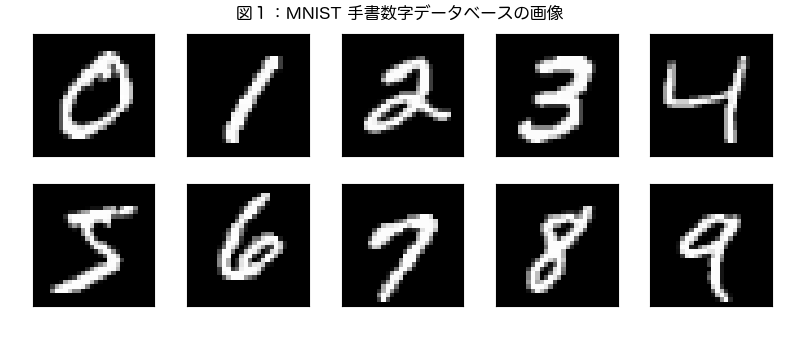

In [4]:
fig, ((ax0, ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8, ax9)) = plt.subplots(2, 5, figsize=(8,3.4))

for i,ax in enumerate([ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]):
    idx = np.where(y_train[0:20]==i)[0][0]
    ax.imshow(x_train[idx], cmap='gray')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

plt.subplots_adjust(top=0.91)
plt.tight_layout(pad=2.0)
#plt.subplots_tool()
plt.suptitle('図１：MNIST 手書数字データベースの画像')
plt.show()

## Reshape data

In [8]:
batch_size = 128
num_classes = 10
epochs = 12

img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_validate = x_validate.reshape(x_validate.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_validate = x_validate.reshape(x_validate.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [9]:
x_train = x_train.astype('float32')
x_validate = x_validate.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_validate /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_validate.shape[0], 'validation samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
9996 validation samples
4 test samples


In [10]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_validate = keras.utils.to_categorical(y_validate, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [11]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

W0818 23:17:53.095110 140735751172992 deprecation_wrapper.py:119] From /Users/brooke/anaconda3/envs/nextgen/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0818 23:17:53.108528 140735751172992 deprecation_wrapper.py:119] From /Users/brooke/anaconda3/envs/nextgen/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0818 23:17:53.111066 140735751172992 deprecation_wrapper.py:119] From /Users/brooke/anaconda3/envs/nextgen/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0818 23:17:53.138086 140735751172992 deprecation_wrapper.py:119] From /Users/brooke/anaconda3/envs/nextgen/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is d

In [12]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

W0818 23:17:53.868423 140735751172992 deprecation_wrapper.py:119] From /Users/brooke/anaconda3/envs/nextgen/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0818 23:17:53.875429 140735751172992 deprecation_wrapper.py:119] From /Users/brooke/anaconda3/envs/nextgen/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [13]:
history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                shuffle=True,
                verbose=1,
                validation_data=(x_validate, y_validate))
score = model.evaluate(x_validate, y_validate, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

W0818 23:17:54.503496 140735751172992 deprecation.py:323] From /Users/brooke/anaconda3/envs/nextgen/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 9996 samples
Epoch 1/12
60000/60000 [==============================] - 62s 1ms/step - loss: 0.2778 - acc: 0.9139 - val_loss: 0.0573 - val_acc: 0.9817
Epoch 2/12
60000/60000 [==============================] - 61s 1ms/step - loss: 0.0914 - acc: 0.9737 - val_loss: 0.0415 - val_acc: 0.9864
Epoch 3/12
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0682 - acc: 0.9796 - val_loss: 0.0384 - val_acc: 0.9874
Epoch 4/12
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0557 - acc: 0.9836 - val_loss: 0.0336 - val_acc: 0.9883
Epoch 5/12
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0497 - acc: 0.9846 - val_loss: 0.0321 - val_acc: 0.9888
Epoch 6/12
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0449 - acc: 0.9867 - val_loss: 0.0304 - val_acc: 0.9895
Epoch 7/12
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0419 - acc: 0.9874 - val_loss: 0.0289 - val_acc:

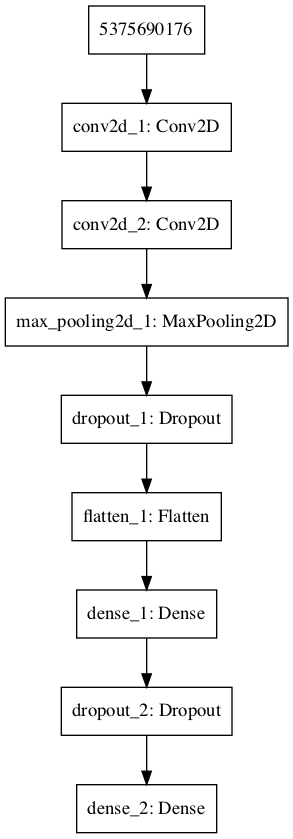

In [14]:
import IPython
from keras.utils import plot_model
plot_model(model, to_file='my_model.png')

IPython.display.Image('my_model.png')

In [ ]:
model.save('my_model.h5')

## TEST

In [15]:
model.predict_classes(x_test)

array([3, 7, 2, 6])

In [16]:
np.where(y_test==1)[1]

array([3, 7, 2, 6])

<IPython.core.display.Javascript object>


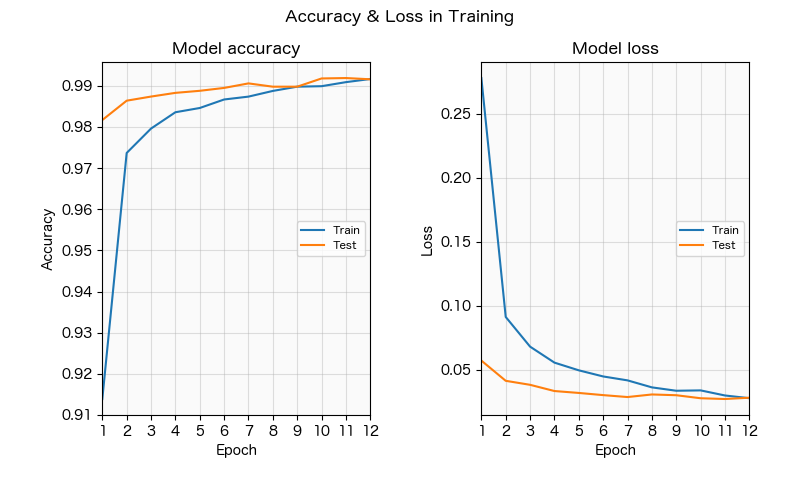

In [17]:
_, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(8,5))

# graph for training & validation accuracy values
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])

ax1.set_title(r'Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_xlim(0,epochs-1)
ax1.xaxis.set_major_locator(plt.MultipleLocator(1))
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda value,tick_number: int(value+1)))
ax1.legend(['Train', 'Test'], loc='center right', fontsize=8)
ax1.set_facecolor('0.98')
ax1.grid(alpha=0.4, zorder=1)

# graph for training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])

ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_xlim(0,epochs-1)
ax2.xaxis.set_major_locator(plt.MultipleLocator(1))
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda value,tick_number: int(value+1)))
ax2.legend(['Train', 'Test'], loc='center right', fontsize=8)
ax2.set_facecolor('0.98')
ax2.grid(alpha=0.4, zorder=1)

plt.suptitle(r'Accuracy & Loss in Training')
plt.tight_layout(pad=3)
plt.show()

In [5]:
x_test[0].reshape((28,28)).flatten().shape

(784,)

<IPython.core.display.Javascript object>


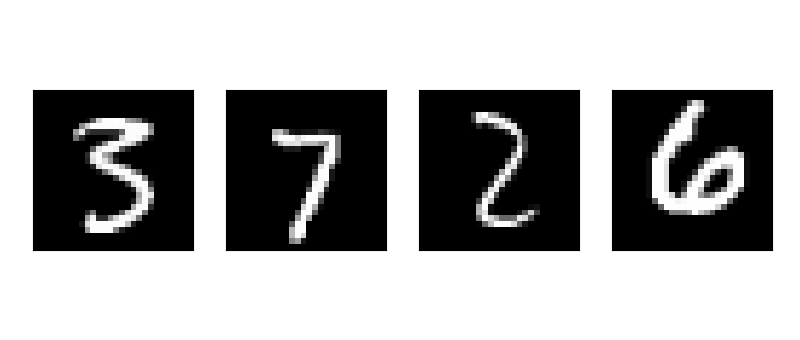

In [20]:
_, ((ax0, ax1, ax2, ax3)) = plt.subplots(1, 4, figsize=(8,3.4))

for i,ax in enumerate([ax0, ax1, ax2, ax3]):
    ax.imshow(x_test[i].reshape((28,28)), cmap='gray')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

plt.subplots_adjust(top=0.91)
plt.tight_layout(pad=2.0)
#plt.subplots_tool()
#plt.suptitle('図：MNIST 手書数字データベースの画像')
plt.show()